Starting PSO Clustering...
Iteration 20/100, Best Fitness: 170.4650
Iteration 40/100, Best Fitness: 165.7097
Iteration 60/100, Best Fitness: 164.0407
Iteration 80/100, Best Fitness: 163.7738
Iteration 100/100, Best Fitness: 163.7482

Final Best Fitness: 163.7482

Cluster Distribution:
Cluster
0    62
1    41
2    33
3    24
4    40
Name: count, dtype: int64


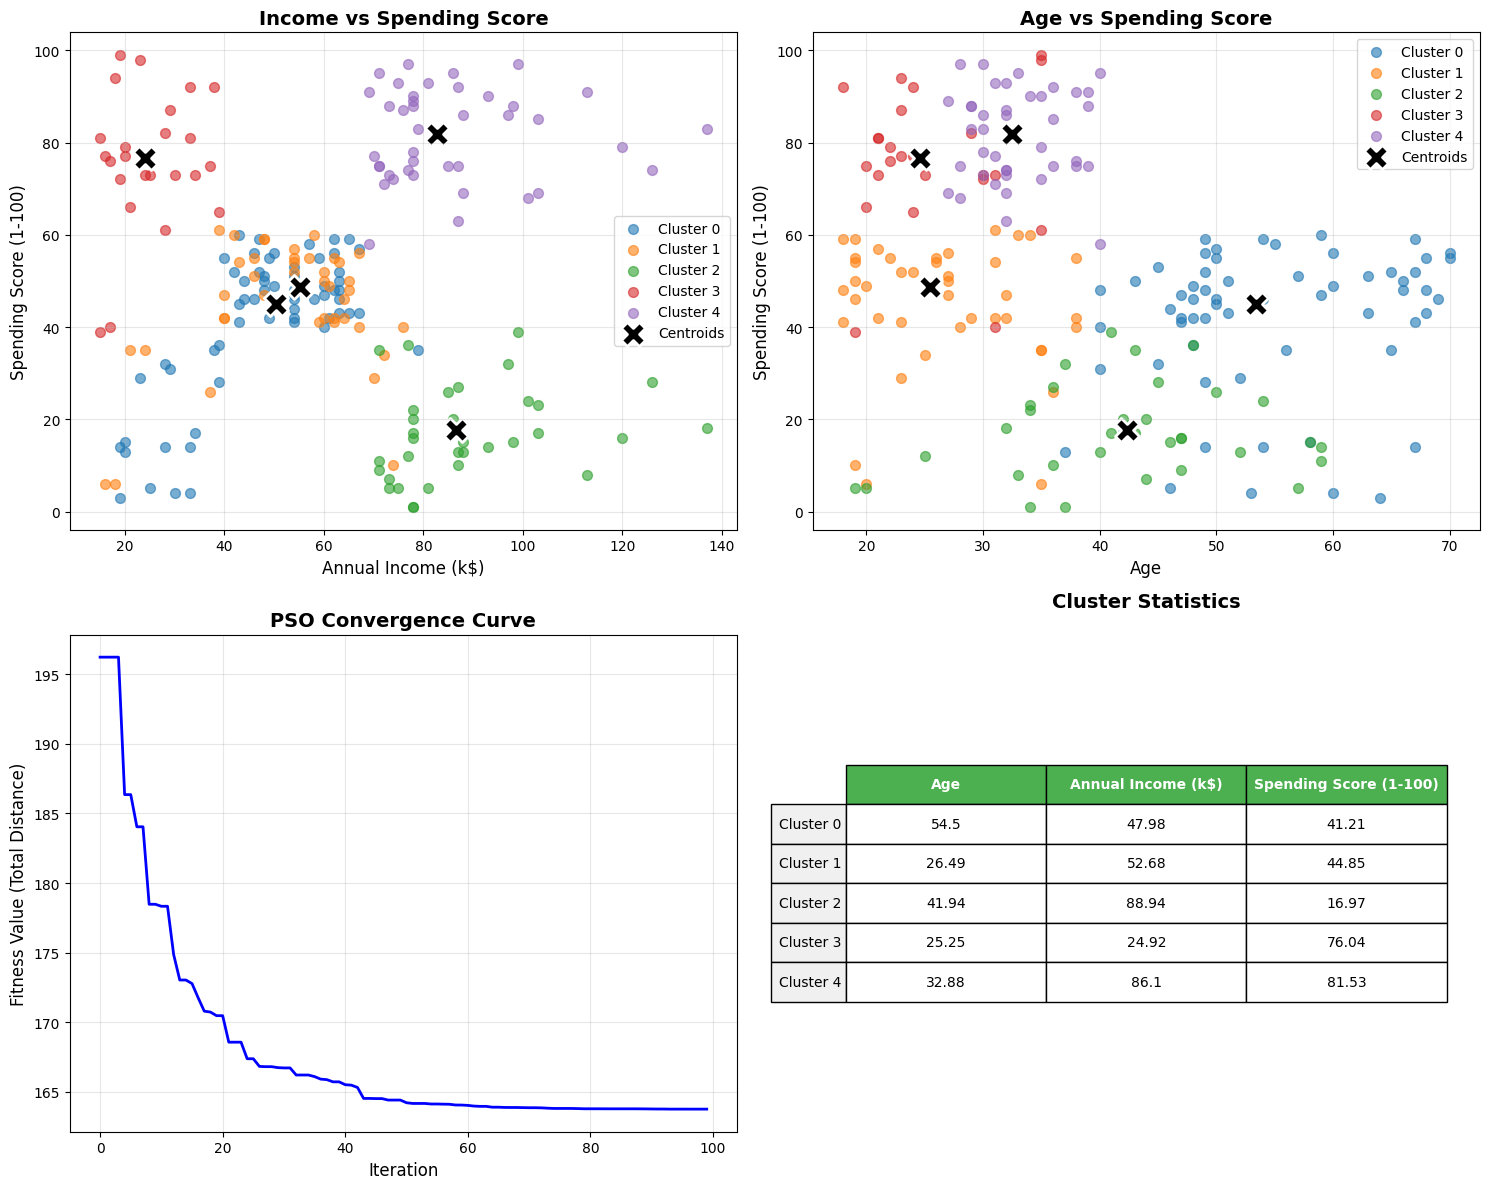


Cluster Statistics:
           Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                   
0        54.50               47.98                   41.21
1        26.49               52.68                   44.85
2        41.94               88.94                   16.97
3        25.25               24.92                   76.04
4        32.88               86.10                   81.53

Clustering completed successfully!
Visualization saved as 'pso_clustering_results.png'


'\nEXPLANATION OF PARTICLE SWARM OPTIMIZATION FOR CLUSTERING:\n\n1. ALGORITHM OVERVIEW:\n   - PSO is a population-based metaheuristic optimization algorithm inspired by social behavior of bird flocking\n   - Each particle represents a potential solution (set of cluster centroids)\n   - Particles move through the solution space searching for optimal centroid positions\n   - Movement is influenced by particle\'s own experience and swarm\'s collective knowledge\n\n2. KEY COMPONENTS:\n   - Particles: Each particle stores cluster centroids (n_clusters × n_features matrix)\n   - Velocity: Direction and speed of particle movement in solution space\n   - Personal Best: Best position each particle has achieved\n   - Global Best: Best position found by entire swarm\n   - Fitness Function: Sum of distances from points to their nearest centroids (minimize intra-cluster distance)\n\n3. PSO PARAMETERS:\n   - w (inertia weight = 0.7): Controls exploration vs exploitation balance\n     Higher w → more

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class ParticleSwarmClustering:
    def __init__(self, n_clusters=5, n_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5):
        self.n_clusters = n_clusters
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.global_best_position = None
        self.global_best_fitness = float('inf')

    def euclidean_distance(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2, axis=1))

    def assign_clusters(self, data, centroids):
        distances = np.zeros((data.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = self.euclidean_distance(data, centroids[i])
        return np.argmin(distances, axis=1)

    def fitness_function(self, centroids, data):
        labels = self.assign_clusters(data, centroids)
        total_distance = 0
        for i in range(self.n_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                distances = self.euclidean_distance(cluster_points, centroids[i])
                total_distance += np.sum(distances)
        return total_distance

    def initialize_particles(self, data):
        n_features = data.shape[1]
        particles = []
        velocities = []

        for _ in range(self.n_particles):
            centroids = np.zeros((self.n_clusters, n_features))
            for j in range(self.n_clusters):
                random_idx = np.random.randint(0, data.shape[0])
                centroids[j] = data[random_idx] + np.random.randn(n_features) * 0.1

            particles.append(centroids)
            velocities.append(np.random.randn(self.n_clusters, n_features) * 0.1)

        return np.array(particles), np.array(velocities)

    def fit(self, data):
        particles, velocities = self.initialize_particles(data)
        personal_best_positions = particles.copy()
        personal_best_fitness = np.array([self.fitness_function(p, data) for p in particles])

        self.global_best_fitness = np.min(personal_best_fitness)
        self.global_best_position = particles[np.argmin(personal_best_fitness)].copy()

        fitness_history = []

        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                r1 = np.random.random((self.n_clusters, data.shape[1]))
                r2 = np.random.random((self.n_clusters, data.shape[1]))

                velocities[i] = (self.w * velocities[i] +
                                self.c1 * r1 * (personal_best_positions[i] - particles[i]) +
                                self.c2 * r2 * (self.global_best_position - particles[i]))

                particles[i] = particles[i] + velocities[i]

                fitness = self.fitness_function(particles[i], data)

                if fitness < personal_best_fitness[i]:
                    personal_best_fitness[i] = fitness
                    personal_best_positions[i] = particles[i].copy()

                    if fitness < self.global_best_fitness:
                        self.global_best_fitness = fitness
                        self.global_best_position = particles[i].copy()

            fitness_history.append(self.global_best_fitness)

            if (iteration + 1) % 20 == 0:
                print(f"Iteration {iteration + 1}/{self.max_iter}, Best Fitness: {self.global_best_fitness:.4f}")

        return fitness_history

    def predict(self, data):
        return self.assign_clusters(data, self.global_best_position)

df = pd.read_csv('SCOA_A7.csv')

features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pso = ParticleSwarmClustering(n_clusters=5, n_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5)

print("Starting PSO Clustering...")
print("=" * 50)
fitness_history = pso.fit(features_scaled)

labels = pso.predict(features_scaled)
df['Cluster'] = labels

print("\n" + "=" * 50)
print(f"Final Best Fitness: {pso.global_best_fitness:.4f}")
print("\nCluster Distribution:")
print(df['Cluster'].value_counts().sort_index())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0, 0]
for cluster in range(5):
    cluster_data = df[df['Cluster'] == cluster]
    ax1.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'],
                label=f'Cluster {cluster}', alpha=0.6, s=50)
centroids_original = scaler.inverse_transform(pso.global_best_position)
ax1.scatter(centroids_original[:, 1], centroids_original[:, 2],
            c='black', marker='X', s=300, edgecolors='white', linewidths=2, label='Centroids')
ax1.set_xlabel('Annual Income (k$)', fontsize=12)
ax1.set_ylabel('Spending Score (1-100)', fontsize=12)
ax1.set_title('Income vs Spending Score', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for cluster in range(5):
    cluster_data = df[df['Cluster'] == cluster]
    ax2.scatter(cluster_data['Age'], cluster_data['Spending Score (1-100)'],
                label=f'Cluster {cluster}', alpha=0.6, s=50)
ax2.scatter(centroids_original[:, 0], centroids_original[:, 2],
            c='black', marker='X', s=300, edgecolors='white', linewidths=2, label='Centroids')
ax2.set_xlabel('Age', fontsize=12)
ax2.set_ylabel('Spending Score (1-100)', fontsize=12)
ax2.set_title('Age vs Spending Score', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.plot(fitness_history, linewidth=2, color='blue')
ax3.set_xlabel('Iteration', fontsize=12)
ax3.set_ylabel('Fitness Value (Total Distance)', fontsize=12)
ax3.set_title('PSO Convergence Curve', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
cluster_stats = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).round(2)
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=cluster_stats.values,
                  colLabels=cluster_stats.columns,
                  rowLabels=[f'Cluster {i}' for i in cluster_stats.index],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(cluster_stats.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(len(cluster_stats)):
    table[(i+1, -1)].set_facecolor('#f0f0f0')
ax4.set_title('Cluster Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('pso_clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 50)
print("Cluster Statistics:")
print(cluster_stats)
print("\nClustering completed successfully!")
print("Visualization saved as 'pso_clustering_results.png'")

"""
EXPLANATION OF PARTICLE SWARM OPTIMIZATION FOR CLUSTERING:

1. ALGORITHM OVERVIEW:
   - PSO is a population-based metaheuristic optimization algorithm inspired by social behavior of bird flocking
   - Each particle represents a potential solution (set of cluster centroids)
   - Particles move through the solution space searching for optimal centroid positions
   - Movement is influenced by particle's own experience and swarm's collective knowledge

2. KEY COMPONENTS:
   - Particles: Each particle stores cluster centroids (n_clusters × n_features matrix)
   - Velocity: Direction and speed of particle movement in solution space
   - Personal Best: Best position each particle has achieved
   - Global Best: Best position found by entire swarm
   - Fitness Function: Sum of distances from points to their nearest centroids (minimize intra-cluster distance)

3. PSO PARAMETERS:
   - w (inertia weight = 0.7): Controls exploration vs exploitation balance
     Higher w → more exploration, lower w → more exploitation
   - c1 (cognitive parameter = 1.5): Weight for personal best attraction
   - c2 (social parameter = 1.5): Weight for global best attraction
   - n_particles (30): Population size - more particles = better exploration but slower
   - max_iter (100): Maximum iterations for convergence

4. VELOCITY UPDATE EQUATION:
   v(t+1) = w*v(t) + c1*r1*(pbest - x(t)) + c2*r2*(gbest - x(t))

   Components:
   - w*v(t): Inertia - maintains current direction
   - c1*r1*(pbest - x(t)): Cognitive component - pulls toward particle's best
   - c2*r2*(gbest - x(t)): Social component - pulls toward swarm's best
   - r1, r2: Random values [0,1] for stochastic behavior

5. POSITION UPDATE:
   x(t+1) = x(t) + v(t+1)
   New centroid positions = old positions + velocity

6. ALGORITHM FLOW:
   Step 1: Initialize particles with random centroid positions near data points
   Step 2: Evaluate fitness (total distance) for each particle
   Step 3: Update personal best if current fitness is better
   Step 4: Update global best if any personal best is better than global best
   Step 5: Calculate new velocities using velocity update equation
   Step 6: Update particle positions using position update equation
   Step 7: Repeat steps 2-6 until max iterations or convergence

7. FITNESS FUNCTION:
   - Assigns each data point to nearest centroid (Euclidean distance)
   - Calculates sum of all distances from points to their cluster centroids
   - Lower fitness = better clustering (compact clusters)

8. ADVANTAGES OF PSO FOR CLUSTERING:
   - Global search capability: Less likely to get stuck in local optima compared to K-means
   - No gradient required: Works with non-differentiable objective functions
   - Simple implementation: Few parameters to tune
   - Parallel search: Multiple particles explore solution space simultaneously
   - Adaptive: Particles share information and adjust search direction

9. COMPARED TO K-MEANS:
   - K-means: Fast but prone to local optima, depends on initialization
   - PSO: Slower but better global search, less sensitive to initialization
   - PSO explores multiple solutions simultaneously while K-means follows single path

10. DATA PREPROCESSING:
    - StandardScaler normalizes features to mean=0, std=1
    - Essential because features have different scales (Age: 18-70, Income: 15-137, Score: 1-100)
    - Without scaling, features with larger ranges would dominate distance calculations

11. RESULTS INTERPRETATION:
    - Convergence curve shows fitness decreasing over iterations
    - Final clusters represent customer segments with similar characteristics
    - Centroids represent "typical" customer in each segment
    - Can be used for targeted marketing strategies

12. IMPLEMENTATION DETAILS:
    - Uses NumPy for efficient matrix operations
    - Vectorized distance calculations for speed
    - Real-time progress reporting every 20 iterations
    - Visualization shows clusters in 2D feature spaces and convergence behavior

13. PRACTICAL APPLICATIONS:
    - Customer segmentation for marketing campaigns
    - Product recommendation based on cluster characteristics
    - Resource allocation to high-value customer segments
    - Understanding customer behavior patterns
"""